In [1]:
import mmml
import matplotlib.pyplot as plt
import patchworklib as pw
import os
from pathlib import Path
import numpy as np
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import jax
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())

[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


<Figure size 100x100 with 0 Axes>

In [2]:
from mmml import dcmnet

In [3]:
import jax

from mmml.dcmnet.dcmnet.data import prepare_datasets
from mmml.dcmnet.dcmnet.modules import MessagePassingModel
from mmml.dcmnet.dcmnet.training import train_model, train_model_dipo

key = jax.random.PRNGKey(0)


In [4]:
NDCM = 4
model = MessagePassingModel(
    features=128, max_degree=2, num_iterations=3,
    num_basis_functions=64, cutoff=8.0, n_dcm=NDCM,
    include_pseudotensors=False,
)

## Data

In [5]:
# current_path = Path.cwd()
# print(current_path)
# data_path = Path("/mnt/d/data")
# data_files = list(data_path.glob("*npz"))
# for i in range(len(data_files)):
#     print(i, data_files[i])

In [6]:
index = 30
data_path_resolved = Path('/home/ericb/testmmml/test.npz') #data_files[index].resolve()
data_loaded = np.load(data_path_resolved, 
allow_pickle=True)
data_path_resolved

PosixPath('/home/ericb/testmmml/test.npz')

In [7]:
# factorize a number
def factorize(n):
    factors = []
    for i in range(1, n + 1):
        if n % i == 0:
            factors.append(i)
    return factors

factorize(data_loaded["esp"].shape[1])

[1, 2, 5, 10, 4451, 8902, 22255, 44510]

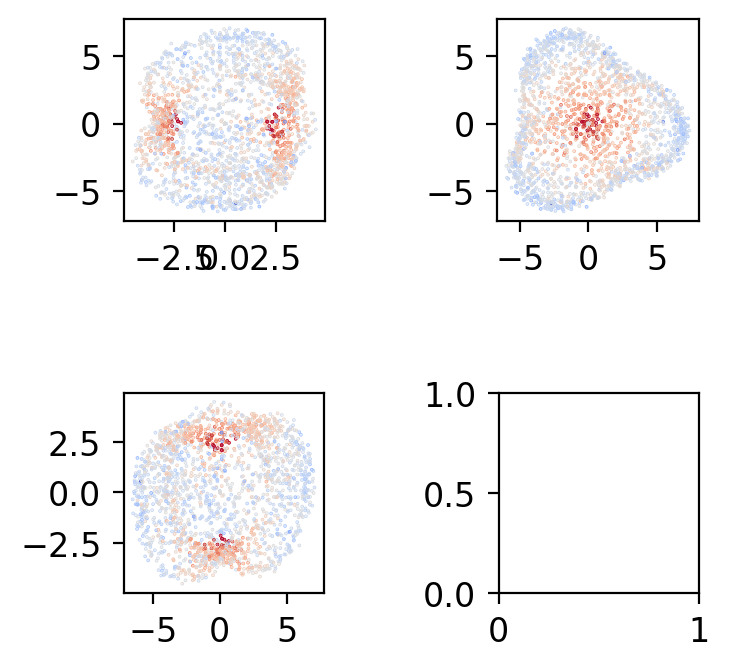

In [8]:
MAT = data_loaded["esp"]
from patchworklib import Brick
NSTEPS = 10
vrang = 4
ax1 = Brick()
ax1.scatter(data_loaded["esp_grid"][0][:,1][::NSTEPS], data_loaded["esp_grid"][0][:,2][::NSTEPS], s=0.1, c=MAT[0][::NSTEPS], cmap="coolwarm", vmin=-vrang, vmax=vrang)

ax2 = Brick()
ax2.scatter(data_loaded["esp_grid"][0][:,0][::NSTEPS], data_loaded["esp_grid"][0][:,2][::NSTEPS], s=0.1, c=MAT[0][::NSTEPS], cmap="coolwarm", vmin=-vrang, vmax=vrang)

ax3 = Brick()
s = ax3.scatter(data_loaded["esp_grid"][0][:,2][::NSTEPS], data_loaded["esp_grid"][0][:,1][::NSTEPS], s=0.1, c=MAT[0][::NSTEPS], cmap="coolwarm", vmin=-vrang, vmax=vrang)

ax4 = Brick()
(ax1 | ax2) / (ax3 | ax4)


R
(1983, 18, 3)
D
(1983, 3)


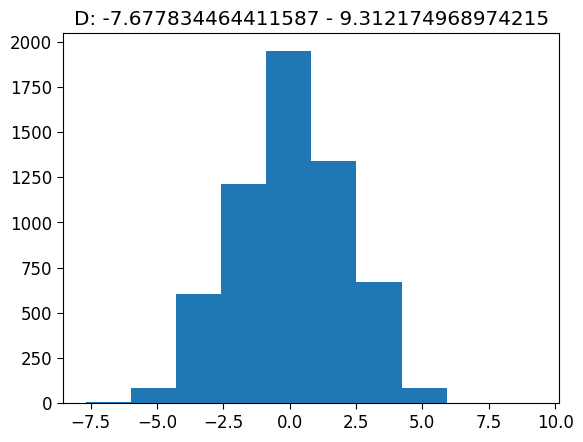

Q
(1983, 3, 3)
Z
(1983, 18)


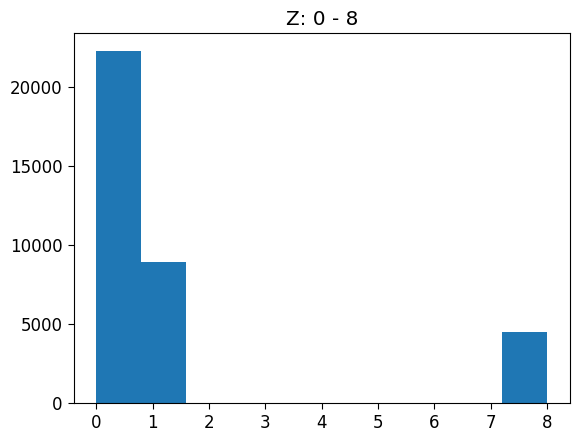

esp
(1983, 44510)


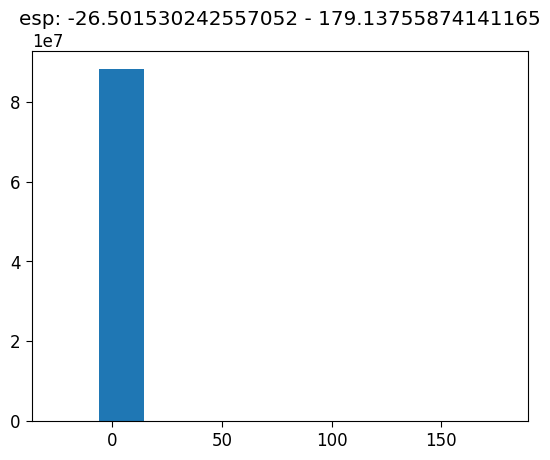

esp_grid
(1983, 44510, 3)
F
(1983, 18, 3)


In [9]:
for k in data_loaded.keys():
    
    print(k)
    shape = data_loaded[k].shape
    print(shape
    )
    if len(shape) < 3:
        try:
            d = data_loaded[k]
            d = d.flatten()
            plt.hist(d)
            title = f"{k}: {d.min()} - {d.max()}"
            plt.title(title)
            plt.show()
        except:
            pass

In [10]:
prepare_datasets?

Signature:
prepare_datasets(
    key,
    num_train,
    num_valid,
    filename,
    clean=False,
    esp_mask=False,
    clip_esp=False,
    natoms=60,
)
Docstring:
Prepare datasets for training and validation.

Wrapper function that calls prepare_multiple_datasets and then
creates train/validation splits and dictionaries.

Parameters
----------
key : jax.random.PRNGKey
    Random key for dataset shuffling
num_train : int
    Number of training samples
num_valid : int
    Number of validation samples
filename : str or list
    Filename(s) to load datasets from
clean : bool, optional
    Whether to filter failed calculations, by default False
esp_mask : bool, optional
    Whether to create ESP masks, by default False
clip_esp : bool, optional
    Whether to clip ESP to first 1000 points, by default False
natoms : int, optional
    Maximum number of atoms per system, by default 60

Returns
-------
tuple
    A tuple containing train_data and valid_data dictionaries
File:      ~/mmml/mmm

In [11]:
data_key = jax.random.PRNGKey(0)

train_data, valid_data = prepare_datasets(
    data_key, num_train=1000, num_valid=100,
    filename=[data_path_resolved],
    clean=False, esp_mask=False,
    natoms=18,
    clip_esp=False,
)


shape (1983, 18, 3)
D (1983, 3)
Q 3 (1983, 3, 3) 1983
Q (1983, 3, 3)
R (1983, 18, 3)
(1983, 18, 3)
['R', 'Z', 'F', 'esp', 'D', 'esp_grid', 'Q']
1983
0 R 1983 (1983, 18, 3)
1 Z 1983 (1983, 18)
2 F 1983 (1983, 18, 3)
3 esp 1983 (1983, 44510)
4 D 5949 (5949, 1)
5 esp_grid 1983 (1983, 44510, 3)
6 Q 1983 (1983, 3, 3)


In [12]:
valid_data["Z"]

array([[8, 1, 1, ..., 0, 0, 0],
       [8, 1, 1, ..., 0, 0, 0],
       [8, 1, 1, ..., 0, 0, 0],
       ...,
       [8, 1, 1, ..., 0, 0, 0],
       [8, 1, 1, ..., 0, 0, 0],
       [8, 1, 1, ..., 0, 0, 0]], dtype=int32)

In [13]:
n_sample = 9000  # Number of points to keep

def random_sample_esp(esp, esp_grid, n_sample, seed=42):
    np.random.seed(seed)
    sampled_esp = []
    sampled_grid = []
    
    for i in range(len(esp)):
        indices = np.random.choice(esp.shape[1], n_sample, replace=False)
        indices = np.sort(indices)  # Keep them sorted
        sampled_esp.append(esp[i][indices])
        sampled_grid.append(esp_grid[i][indices])
    
    return np.array(sampled_esp), np.array(sampled_grid)

train_data["esp"], train_data["esp_grid"] = random_sample_esp(
    train_data["esp"] , train_data["esp_grid"], n_sample
)
valid_data["esp"], valid_data["esp_grid"] = random_sample_esp(
    valid_data["esp"] , valid_data["esp_grid"], n_sample
)

train_data["vdw_surface"] = train_data["esp_grid"] 
valid_data["vdw_surface"] = valid_data["esp_grid"] 
train_data["n_grid"] = np.full(len(train_data["vdw_surface"]), n_sample)
valid_data["n_grid"] = np.full(len(valid_data["vdw_surface"]), n_sample)


train_data["vdw_surface"] = train_data["esp_grid"]
valid_data["vdw_surface"] = valid_data["esp_grid"]

Hs_train = train_data["Z"] == 1.0
Os_train = train_data["Z"] == 8.0
Hs_valid = valid_data["Z"] == 1.0
Os_valid = valid_data["Z"] == 8.0

# train_data["mono"] = np.zeros_like(train_data["Z"])
# valid_data["mono"] = np.zeros_like(valid_data["Z"])

train_data["mono"] = Hs_train * 0.1 + Os_train * -0.2
valid_data["mono"] = Hs_valid * 0.1 + Os_valid * -0.2

# Fix n_grid shape
train_data["n_grid"] = np.full(train_data["Z"].shape[0], 44510)
valid_data["n_grid"] = np.full(valid_data["Z"].shape[0], 44510)

# Fix N shape  
train_data["N"] = np.count_nonzero(train_data["Z"], axis=1)
valid_data["N"] = np.count_nonzero(valid_data["Z"], axis=1)

In [14]:
# # If mono now has shape (num_samples, 18), reshape it to (num_samples, 18) 
# # which becomes (1, 18) when we take batch[0]
# train_data["mono"] = train_data["mono"].reshape(-1, 18)
# valid_data["mono"] = valid_data["mono"].reshape(-1, 18)

In [15]:
# Check current batch shapes
print("After fixes:")
batch = {k: v[0:1] if len(v.shape) > 0 else v for k, v in train_data.items()}
for key in ['mono', 'esp', 'vdw_surface', 'n_grid', 'N', 'R', 'Z']:
    if key in batch:
        print(f"{key}: {batch[key].shape}")

# Also check the specific values
print(f"\nmono values: {batch['mono']}")
print(f"N values: {batch['N']}")
print(f"n_grid values: {batch['n_grid']}")

After fixes:
mono: (1, 18)
esp: (1, 9000)
vdw_surface: (1, 9000, 3)
n_grid: (1,)
N: (1,)
R: (1, 18, 3)
Z: (1, 18)

mono values: [[-0.2  0.1  0.1 -0.2  0.1  0.1  0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0. ]]
N values: [6]
n_grid values: [44510]


In [16]:
esp_data = train_data["esp"]
esp_data.shape

(1000, 9000)

## Training (1)

In [17]:
train_model?

Signature:     
train_model(
    key,
    model,
    train_data,
    valid_data,
    num_epochs,
    learning_rate,
    batch_size,
    writer,
    ndcm,
    esp_w=1.0,
    chg_w=0.01,
    restart_params=None,
    *,
    loss_step_fn: Callable = <PjitFunction of <function train_step at 0x7270f4f9c540>>,
    eval_step_fn: Callable = <PjitFunction of <function eval_step at 0x7270f4b3b7e0>>,
    optimizer_fn: Callable = <function <lambda> at 0x7270f4b60360>,
    use_ema: bool = True,
    ema_decay: float = 0.999,
    use_grad_clip: bool = True,
    grad_clip_norm: float = 2.0,
    log_extra_metrics: Optional[Callable] = <function _log_extra_metrics_none at 0x7270f4b60220>,
    save_best_params_with_ema: bool = True,
    extra_valid_args: dict = None,
    extra_train_args: dict = {'chg_w': 0.01},
)
Call signature: train_model(*args, **kwargs)
Type:           partial
String form:    functools.partial(<function train_model_general at 0x7270f4b60180>, loss_step_fn=<PjitFunction of <...> etric

In [18]:
params, valid_loss = train_model(
    key=data_key, model=model,
    writer=None,
    train_data=train_data, valid_data=valid_data,
    num_epochs=10, learning_rate=1e-4, batch_size=1,
    # restart_params=params if params is None else params,
    ndcm=model.n_dcm, esp_w=100.0, chg_w=0.1, use_grad_clip=True, grad_clip_norm=1.0,
)
new_params = params.copy()


Preparing batches
..................
Epoch 1 train: 2.407348410861486e+17, valid: 3.255600878408696e+18, best: False
Epoch 2 train: 2.4026414703024538e+17, valid: 5.482742879402695e+19, best: False


KeyboardInterrupt: 

In [ ]:
params['params'].keys()



dict_keys(['Dense_0', 'Dense_1', 'Dense_2', 'Dense_3', 'Dense_4', 'Dense_5', 'Dense_6', 'Embed_0', 'MessagePass_0', 'MessagePass_1', 'MessagePass_2', 'TensorDense_0', 'element_bias'])

In [ ]:
from mmml.dcmnet.dcmnet.analysis import dcmnet_analysis, prepare_batch

?dcmnet_analysis
?prepare_batch

Signature: prepare_batch(path: pathlib.Path, index=0, data=None)
Docstring:
Prepare a single batch from data for analysis.

Parameters
----------
path : Path
    Path to the data file
index : int, optional
    Index of the data to prepare
data : dict, optional
    Data dictionary to use instead of loading from file
    
Returns
-------
dict
    Batch dictionary ready for model input
File:      ~/mmml/mmml/dcmnet/dcmnet/analysis.py
Type:      function

In [ ]:
params['params']

{'Dense_0': {'0+': {'bias': Array([-1.09411252e-03, -1.09830098e-02, -1.60567481e-02, -3.18059861e-03,
           1.28124245e-02,  6.96812384e-03, -4.35734354e-03, -3.21489433e-03,
          -2.29503177e-02, -1.97964394e-03, -9.69513692e-03, -8.06437992e-03,
          -5.81941893e-03, -1.02451704e-02,  5.45120984e-03,  3.19876475e-03,
          -1.22344412e-03, -6.53736992e-03,  8.64380226e-03,  2.17648409e-03,
           1.04171294e-03, -7.18041044e-03, -1.00422958e-02,  2.56635481e-03,
          -6.27018558e-03, -2.98503833e-03, -1.08648865e-02, -2.44156527e-03,
           3.11954040e-03,  6.89988164e-03,  8.07544030e-03, -1.59731437e-03,
           1.19630620e-02,  3.66353593e-03, -4.95042419e-04,  4.26584017e-03,
          -6.52485760e-03,  4.58745006e-03, -8.50894302e-03, -1.45237509e-03,
           2.33576540e-03, -3.18957306e-03,  3.94850457e-03,  5.82958804e-03,
           9.65914980e-04,  1.25945993e-02, -4.30360343e-03, -1.02412119e-03,
          -3.03082680e-03, -3.96871148e

In [ ]:
from mmml.dcmnet.dcmnet.data import prepare_batches
from mmml.dcmnet.dcmnet.analysis import dcmnet_analysis

def prepare_batch_for_analysis(data, index=0):
    """Prepare a single batch correctly for dcmnet_analysis."""
    # Extract single item but keep batch dimension
    _dict = {k: np.array(v[[index]]) for k, v in data.items()}
    
    # Use prepare_batches with include_id=True
    batch = prepare_batches(jax.random.PRNGKey(0), _dict, batch_size=1, include_id=True)[0]
    
    return batch

# Use it:
batch = prepare_batch_for_analysis(train_data, index=0)
output = dcmnet_analysis(params, model, batch)
print(f"RMSE: {output['rmse_model']:.6f}")
print(f"RMSE (masked): {output['rmse_model_masked']:.6f}")

IndexError: index 18 is out of bounds for axis 0 with size 18

In [ ]:
batch

In [ ]:
import ase
from ase.visualize import view
atoms = ase.Atoms(batch["Z"][:int(batch["N"])], 
batch["R"][:int(batch["N"])])
view(atoms, viewer="x3d")


In [ ]:
import patchworklib as pw
VMAX = 0.01
xy_ax = pw.Brick()
xy_ax.scatter(batch["esp"], output['esp_pred'], s=1)
max_val = np.sqrt(max(np.max(batch["esp"]**2), np.max(output['esp_pred']**2)))
xy_ax.plot(np.linspace(-max_val, max_val, 100), np.linspace(-max_val, max_val, 100))
xy_ax.set_aspect('equal')

ax_true = pw.Brick()
Npoints = 4150
vdw_surface_min = np.min(batch["vdw_surface"][0], axis=-1)
vdw_surface_max = np.max(batch["vdw_surface"][0], axis=-1)

ax_true.scatter(
    batch["vdw_surface"][0][:Npoints,0], 
batch["vdw_surface"][0][:Npoints,1], 
c=batch["esp"][0][:Npoints],
s=0.01,
    vmin=-VMAX, vmax=VMAX
)
max_val = np.sqrt(max(np.max(batch["esp"]**2), np.max(output['esp_pred']**2)))
# ax.plot(np.linspace(-max_val, max_val, 100), np.linspace(-max_val, max_val, 100))
ax_true.set_aspect('equal')

ax_pred = pw.Brick()

ax_pred.scatter(
    batch["vdw_surface"][0][:Npoints,0], 
batch["vdw_surface"][0][:Npoints,1], 
c=output['esp_pred'][:Npoints],
s=0.01,
    vmin=-VMAX, vmax=VMAX
)
max_val = np.sqrt(max(np.max(batch["esp"]**2), np.max(output['esp_pred']**2)))
# ax.plot(np.linspace(-max_val, max_val, 100), np.linspace(-max_val, max_val, 100))
ax_pred.set_aspect('equal')


ax_diff = pw.Brick()
ax_diff.scatter(
    batch["vdw_surface"][0][:Npoints,0], 
batch["vdw_surface"][0][:Npoints,1], 
c=batch["esp"][0][:Npoints] - output['esp_pred'][:Npoints],
s=0.01,
    vmin=-VMAX, vmax=VMAX
)
ax_diff.set_aspect('equal')

for _ in [ax_pred, ax_true, ax_diff]:
    _.set_xlim(vdw_surface_min[0], -vdw_surface_min[0])
    _.set_ylim(vdw_surface_min[1], -vdw_surface_min[0])


xy_ax | ax_pred | ax_true | ax_diff



In [ ]:
output["mono"][0][:int(batch["N"])].sum(axis=-1)


In [ ]:
charge_ax = pw.Brick()
charge_ax.matshow(output["mono"][0][:int(batch["N"])],vmin=-1,vmax=1)
scharge_ax = pw.Brick()
scharge_ax.matshow(output["mono"][0][:int(batch["N"])].sum(axis=-1)[:, None],vmin=-1,vmax=1)
# scharge_ax.add_colorbar(vmin=-1,vmax=1)
scharge_ax.axis("off")
f = (scharge_ax | charge_ax)
f.add_colorbar(vmin=-1,vmax=1)

In [ ]:
R = output["dipo"][:int(batch["N"])*NDCM]
Z = np.array([1 if _ > 0 else 1 for _ in output["mono"][0][:int(batch["N"])].flatten()])
R.shape, Z.shape
dcm_atoms = ase.Atoms(Z, R)
view(dcm_atoms,  viewer="x3d")

In [ ]:
new_params, valid_loss = train_model(
    key=key, model=model,
    writer=None,
    train_data=train_data, valid_data=valid_data,
    num_epochs=100, learning_rate=5e-4, batch_size=1,
    ndcm=model.n_dcm, esp_w=1000.0,
    restart_params=params if new_params is None else new_params,
)